,File,Throughput (tokens/sec),TTFT (ms),ITL (ms),E2E Latency (ms),successful,errored,incomplete,total,MAX_CONCURRENCY
0,throughput-1.json,176.965186,142.620335,14.926890,1083.368526,100,0,0,100,1
1,throughput-10.json,492.774674,555.116994,52.980308,3893.126578,100,0,0,100,10
2,throughput-100.json,597.971759,11746.873300,231.189425,26311.972041,100,0,0,100,100
3,throughput-15.json,608.673142,612.222509,61.899358,4512.113574,100,0,0,100,15
4,throughput-25.json,993.307350,771.444378,64.210789,4816.924899,100,0,0,100,25
5,throughput-30.json,1157.882230,722.459881,55.824572,4239.600236,100,0,0,100,30
6,throughput-35.json,701.864868,784.677291,134.162130,9237.067313,100,0,0,100,35
7,throughput-40.json,782.538877,1280.647635,120.083341,8846.103189,100,0,0,100,40
8,throughput-45.json,678.436699,1333.516099,158.851499,11341.336625,100,0,0,100,45
9,throughput-5.json,268.788003,238.814268,52.910468,3572.441292,100,0,0,100,5


✅ Summary saved to benchmark_metrics_summary.csv


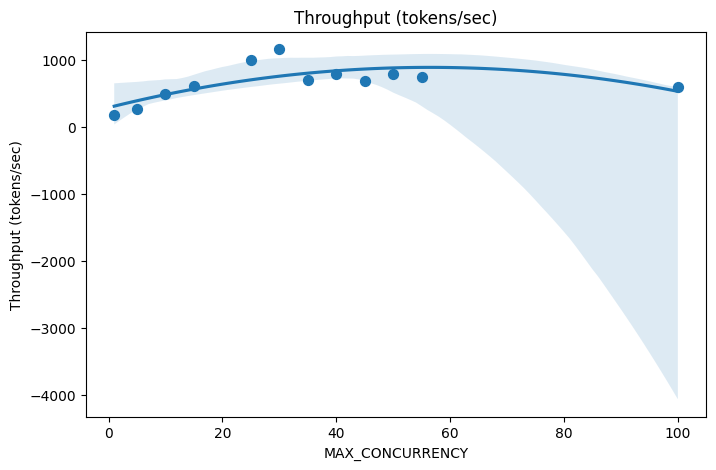

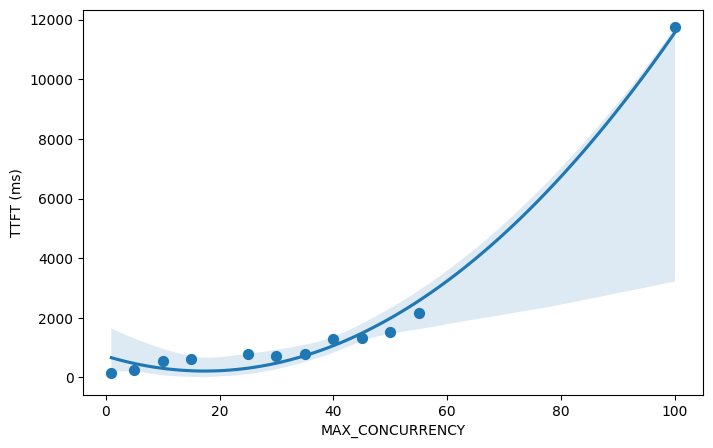

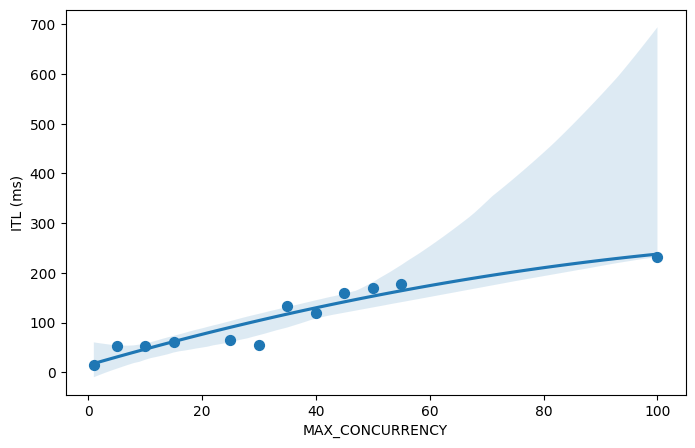

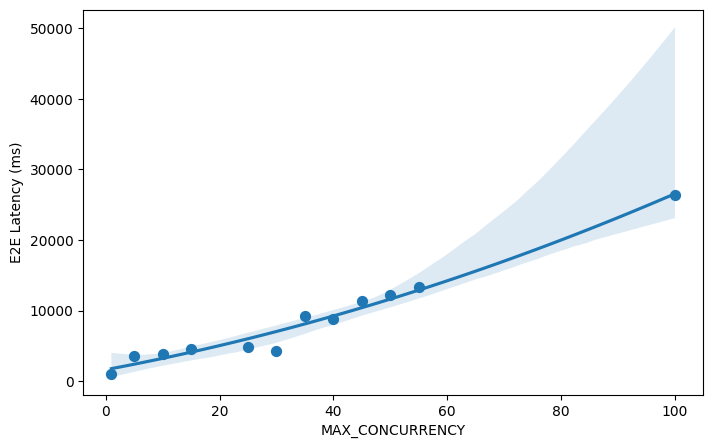

In [ ]:
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np
# === CONFIG ===
# Point to your benchmark files (you can add/remove as needed)
folder_name = 'benchmark-results'
os.makedirs(folder_name, exist_ok=True)
benchmark_files = [
    Path(folder_name)/file for file in os.listdir(folder_name)
]

rows = []

def extract_metric(metrics, name, key="mean"):
    """Safely extract a metric from GuideLLM JSON"""
    m = metrics.get(name, {})
    if isinstance(m, dict):
        for scope in ("total", "successful"):
            part = m.get(scope, {})
            if isinstance(part, dict):
                if key in part:
                    return part[key]
                if "percentiles" in part and key in part["percentiles"]:
                    return part["percentiles"][key]
    return None

for f in benchmark_files:
    if not f.exists():
        print(f"⚠️ File not found: {f}")
        continue

    data = json.load(open(f))
    benchmarks = data.get("benchmarks", [])
    if not benchmarks:
        print(f"⚠️ No benchmarks found in {f}")
        continue

    b = benchmarks[-1]  # take last benchmark run
    metrics = b.get("metrics", {})
    requests_made =  b.get("run_stats", {})["requests_made"]
    # Extract metrics
    tokens_per_sec = extract_metric(metrics, "tokens_per_second")
    ttft_ms = extract_metric(metrics, "time_to_first_token_ms")
    itl_ms = extract_metric(metrics, "inter_token_latency_ms")
    avg_latency_s = extract_metric(metrics, "request_latency")
    successful = requests_made["successful"]
    errored = requests_made["errored"]
    incomplete = requests_made["incomplete"]
    total = requests_made["successful"]
    avg_latency_ms = avg_latency_s * 1000 if avg_latency_s else None

    rows.append({
        "File": f.name,
        "Throughput (tokens/sec)": tokens_per_sec,
        "TTFT (ms)": ttft_ms,
        "ITL (ms)": itl_ms,
        "E2E Latency (ms)": avg_latency_ms,
        "successful" : successful,
        "errored" : errored,
        "incomplete" : incomplete,
        "total" : total

    })

df = pd.DataFrame(rows)
df["MAX_CONCURRENCY"] = df["File"].apply(lambda st: st[st.find("-")+1:st.find(".")]).astype('int64')
display(df)

# === PLOTTING ===
plt.figure(figsize=(8, 5))
plt.title("Throughput (tokens/sec)")
sns.regplot(data=df, x="MAX_CONCURRENCY", y="Throughput (tokens/sec)", x_estimator=np.mean, order=2)
plt.savefig('throughput.png')

plt.figure(figsize=(8, 5))
sns.regplot(data=df, x="MAX_CONCURRENCY", y="TTFT (ms)", x_estimator=np.mean, order=2)
plt.savefig('TTFT.png')

plt.figure(figsize=(8, 5))
sns.regplot(data=df, x="MAX_CONCURRENCY", y="ITL (ms)", x_estimator=np.mean, order=2)
plt.savefig('ITL.png')

plt.figure(figsize=(8, 5))
sns.regplot(data=df, x="MAX_CONCURRENCY", y="E2E Latency (ms)", x_estimator=np.mean, order=2)
plt.savefig('E2E.png')
# Optionally save to CSV for later analysis
output_csv = "benchmark_metrics_summary.csv"
df.to_csv(output_csv, index=False)
print(f"✅ Summary saved to {output_csv}")
